# Test the sensitivity of the annual estimates of modeled Bering Strait Transports
This notebook tests the sensitivity of the Bering Strait Woodgate mooring transport estimate using `vmo` from OM4 forced with JRA55.

Transport $V_{vol} = vo \times Area_{BS}$ is estimated from the model for every grid point and annually averaged. Errorbars for the mooring transport estimate is defined as the range in $V_{vol}$ for all the bottom grid points. The linear regression of transport calculated from each grid point is also calculated.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
import cmocean

## Set parameters

In [3]:
# Model reference density [kg/m3]
rho_0 = 1035
# Lat, Lon, depth of mooring observations
llz = [66 + (19.6/60), -168 - (57.5/60), 57]
# Cross-sectional area of strait [m^2]
area_BS = 4.25e6

## Set paths

In [4]:
## OM4 with JRA forcing
# base
base_om4 = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/'
# historical
om4_HI = base_om4 + 'OM4p25_JRA55do1.4_0netfw_cycle6/gfdl.ncrc4-intel16-prod/pp/ocean_Bering_Strait/'

In [5]:
# base for high res experiments
base_hres = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/'
## ODiv 209
# 1/8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8
odiv209_PI = base_hres + 'CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'

In [6]:
# output directories
om4_HI_dir = om4_HI + 'ts/daily/20yr/'
odiv209_PI_dir = odiv209_PI + 'ts/daily/10yr/'

## Get model file lists

In [7]:
## OM4 with JRA forcing
# historical
filelistOM4 = glob(f'{om4_HI_dir}*.nc')

In [8]:
## ODIV209 CM4
# pi
filelistODIV209 = glob(f'{odiv209_PI_dir}*.nc')

## Read in model data

In [9]:
def open_model_data(flist):
    # open and clean up model data
    DS = xr.open_mfdataset(flist,use_cftime=True,combine='by_coords',engine='netcdf4',
                           drop_variables=['average_DT', 'average_T1', 'average_T2']
                          ).rename_dims({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                       ).rename({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                               ).squeeze()
    return DS

In [10]:
# OM4 with JRA
DS_om4 = open_model_data(filelistOM4).chunk({'time':10000})

In [11]:
# ODIV209 CM4
DS_o209 = open_model_data(filelistODIV209).chunk({'time':30000})
# Fix weirdness with vmo coord
DS_o209['vmo'] = DS_o209.vmo.assign_coords(xh=("xh_sub02", DS_o209.xh)).swap_dims({"xh_sub02": "xh"})
DS_o209['vo'] = DS_o209.vo.assign_coords(xh=("xh_sub02", DS_o209.xh)).swap_dims({"xh_sub02": "xh"})

## Set up DASK cluster
In dask labextension, create a +NEW cluster. Click the < > widget, scale it to 16 workers and let's go!

## Open Ocean Static

In [12]:
# OM4
OS_om4 = xr.open_dataset(om4_HI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

In [13]:
# ODIV209 CM4
OS_o209 = xr.open_dataset(odiv209_PI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

## Assign geolat, geolon, and dy to outputs

In [14]:
def assign_latlon(DS,OS):
    # assign geolat and geolon from ocean static
    DS = DS.assign_coords({'lon':OS['geolon_v'].sel(xh=DS.xh,yq=DS.yq),
                           'lat':OS['geolat_v'].sel(xh=DS.xh,yq=DS.yq)})
    return DS

In [15]:
# OM4
DS_om4 = assign_latlon(DS_om4,OS_om4)

In [16]:
# ODIV209 CM4
DS_o209 = assign_latlon(DS_o209,OS_o209)

## Calculate `V_vol`

In [17]:
DS_om4['V_vol'] = (DS_om4['vo'] * area_BS) + 1e5

In [18]:
DS_o209['V_vol'] = (DS_o209['vo'] * area_BS) + 1e5

## Get annual averages

In [19]:
V_vol = (DS_om4.V_vol*(10**-6)).groupby('time.year').mean()

In [20]:
V_volH = (DS_o209.V_vol*(10**-6)).groupby('time.year').mean()

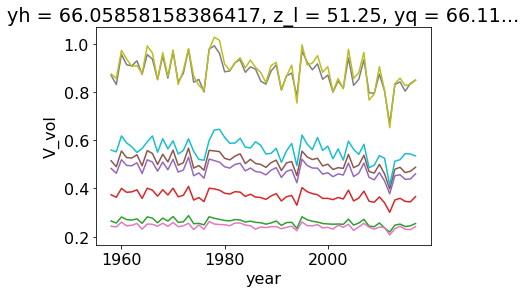

In [54]:
V_vol.sel(z_l=llz[-1],method='nearest').plot.line(x='year',add_legend=False)
plt.show()

In [31]:
Vbar = V_vol.sel(z_l=llz[-1],method='nearest').mean('year').mean('xh').values
Vstd = V_vol.sel(z_l=llz[-1],method='nearest').mean('year').std('xh').values

print('Mean transport estimate: %.2f Sv' %Vbar)
print('STD of mean transport estimate: %.2f Sv' %Vstd)

Mean transport estimate: 0.52 Sv
STD of mean transport estimate: 0.23 Sv


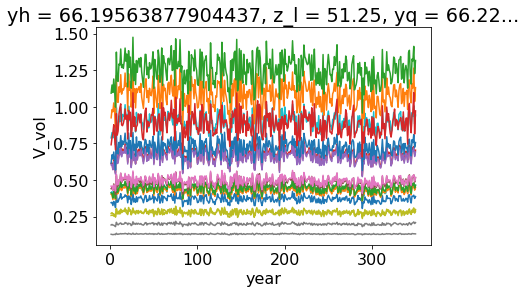

In [25]:
V_volH.sel(z_l=llz[-1],method='nearest').plot.line(x='year',add_legend=False)
plt.show()

In [32]:
Vbar = V_volH.sel(z_l=llz[-1],method='nearest').mean('year').mean('xh').values
Vstd = V_volH.sel(z_l=llz[-1],method='nearest').mean('year').std('xh').values

print('Mean transport estimate: %.2f Sv' %Vbar)
print('STD of mean transport estimate: %.2f Sv' %Vstd)

Mean transport estimate: 0.57 Sv
STD of mean transport estimate: 0.30 Sv


## Linear regression of OM4 run

In [33]:
def mk_lr(da):
    # calc linear regression for chosen months
    lr = da.polyfit('year',1,full=True)
    # rename coefficients
    lr = lr.rename({[s for s in list(lr.keys()) if "coefficients" in s][0]:'b0_b1'})
    # rename sum of squared errors
    lr = lr.rename({[s for s in list(lr.keys()) if "residuals" in s][0]:'SSE'})
    # add sample size
    lr['N'] = len(da.year)
    # calculate the standard error of the estimate
    lr['s_err'] = (lr['SSE']/(lr['N']-2))**(1/2)
    # calc spread in time
    dt = (da.year - da.year.mean()).values
    # calculate the standard error of the slope (dea)
    lr['s_b1'] = lr['s_err']/((dt**2).sum()**(1/2))
    # calc mask for statistical significance
    lr['b1_mask'] = (abs(lr['b0_b1'].sel(degree=1)) < (2*lr['s_b1'])).astype(int)
    return lr

In [34]:
lr = mk_lr(V_vol)

In [35]:
lr = lr.assign_coords({'lon':V_vol['lon'].sel(xh=lr.xh),
                       'lat':V_vol['lat'].sel(xh=lr.xh)})

In [36]:
def bering_section(ds,ax,vMM,inNS):
    # convert units of the trend from ns to years
    if inNS:
        t_con = 1e9 * 86400 * 365.25
    else:
        t_con = 1
    
    # Pull variables for plotting
    x = ds['lon']
    y = ds['z_l']
    z = t_con*ds['b0_b1'].sel(degree=1)
    mask = ds['b1_mask']
    
    # plot trend
    im = ax.pcolormesh(x,y,z,cmap='cmo.balance',vmin=-vMM,vmax=vMM,
                       rasterized=True)
    # add mask
    n_levels = 1
    ax.contourf(x,y,mask,n_levels,colors='none',hatches=['..',None])
    # Zoom in around the Bering Strait
    ax.set_ylim(0,80)
    ax.set_xticks([-170, -169, -168])
    ax.set_xlim(-170.5,-168)
    ax.invert_yaxis()
    return im

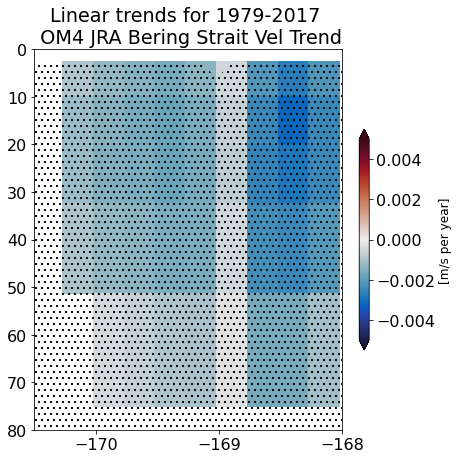

In [37]:
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(6,7))
# transport
im = bering_section(lr,ax,5e-3,False)

# Add colorbar
cbar = plt.colorbar(im,ax=ax,fraction=0.03,pad=0.05,extend='both')
cbar.set_label('[m/s per year]',fontsize=12)

# Additional formatting
plt.title('Linear trends for 1979-2017 \n OM4 JRA Bering Strait Vel Trend')
plt.show()
# save fig
fig.savefig('../figures/TransportFeedback/linearTrend_BSVvel_om4JRA_longterm.pdf')

## Set observational paths

In [38]:
# Volume transport
fname_T = '../data/BeringStraitMooring/BeringStrait_Annualmeans_TRANSPORT_Jan2021.txt'

## Read in observational data

In [39]:
# Volume transport
BST = np.loadtxt(fname_T, comments='%')

## Make observational time series

In [40]:
# Make time array
time = xr.cftime_range(start=BST[0,0].astype('int').astype('str'), periods=BST.shape[0], freq="A-JUN", calendar="noleap")

In [41]:
# Volume transport
T_vol  = BST[:,-2] + 0.1
T_volE = BST[:,-1]

In [42]:
idx = np.isfinite(T_vol)
p, residuals, rank, singular_values, rcond = np.polyfit(time.year[idx],T_vol[idx],1,full=True)
N = len(T_vol[idx])
s_err = (residuals/(N-2))**(1/2)
dt = time.year[idx] - np.mean(time.year[idx])
s_b1 = s_err/((dt**2).sum()**(1/2))

In [43]:
s_b1

array([0.00374931])

In [44]:
p[0]

0.00948568916674771

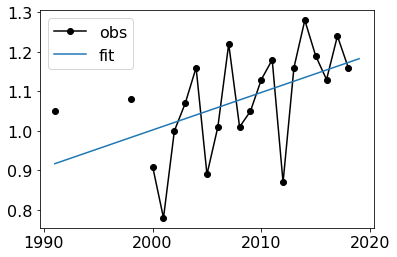

In [45]:
plt.plot(time.year,T_vol,'-ok',label='obs')
plt.plot(time.year,np.polyval(p,time.year),label='fit')
plt.legend()
plt.show()

In [77]:
def matched_index(l1, l2):
    l2 = set(l2)
    return [i for i, el in enumerate(l1) if el in l2]

In [78]:
imod = matched_index(V_vol.year.values,time.year[idx])

In [71]:
V_vol.year.values[imod]

array([1991, 1998, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

In [73]:
time.year[idx][:-1]

array([1991, 1998, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

In [81]:
V_4cor = V_vol.sel(z_l=llz[-1],method='nearest').isel(xh=-5)[imod].values

In [82]:
np.cov(V_4cor,T_vol[idx][:-1])/(np.std(V_4cor)*np.std(T_vol[idx][:-1]))

array([[0.46480224, 0.45561965],
       [0.45561965, 2.38388111]])